In [19]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams['figure.max_open_warning'] = False
%load_ext autoreload
%autoreload 2

In [28]:
class Caller(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        # share max for all weights?
        
        w = [0, 0]
        m = [0, 0]
        w[0] = self.model.layers[0].get_weights()
        m[0] = np.abs(w[0]).max()
        
        w[1] = self.model.layers[1].get_weights()
        m[1] = np.abs(w[1]).max()
        
        mlast = np.array(m).max()
        print('\t ', mlast, m[0], m[1])
        self.model.layers[0].set_weights(w[0] / mlast)
        self.model.layers[1].set_weights(w[1] / mlast)
        
#         self.model.layers[0]
#         self.losses.append(logs.get('loss'))

In [ ]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 6

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, use_bias=False))
model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
#           callbacks=[Caller()]
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('mnist_nobias_pure')


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 75s - loss: 0.3282 - acc: 0.9001 - val_loss: 0.0800 - val_acc: 0.9755
Epoch 2/6
60000/60000 [==============================] - 75s - loss: 0.1119 - acc: 0.9671 - val_loss: 0.0506 - val_acc: 0.9838
Epoch 3/6
60000/60000 [==============================] - 76s - loss: 0.0849 - acc: 0.9753 - val_loss: 0.0438 - val_acc: 0.9850
Epoch 4/6
60000/60000 [==============================] - 75s - loss: 0.0729 - acc: 0.9781 - val_loss: 0.0375 - val_acc: 0.9877
Epoch 5/6
60000/60000 [==============================] - 78s - loss: 0.0622 - acc: 0.9817 - val_loss: 0.0360 - val_acc: 0.9876
Epoch 6/6
51968/60000 [========================>.....] - ETA: 11s - loss: 0.0556 - acc: 0.9831

<IPython.core.display.Javascript object>


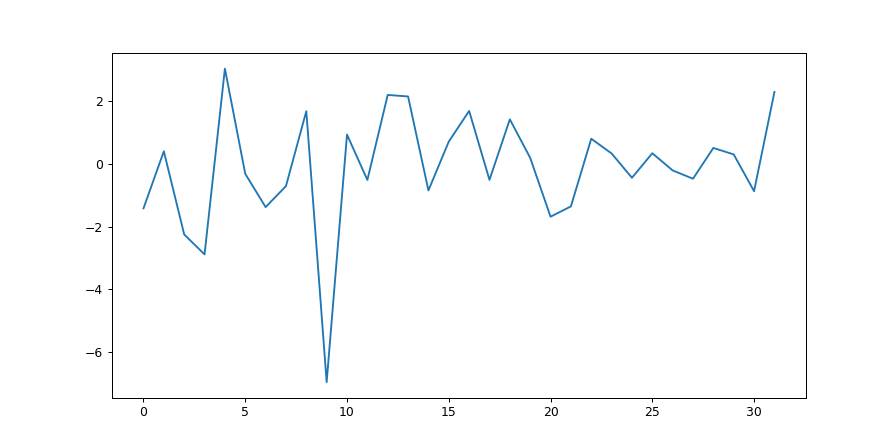

In [30]:
import numpy as np
c0 = model.layers[0].get_weights()[0]
c0s = c0.reshape(32, 3, 3)

s = []
for x in c0s:
    s.append(np.sum(x))
#     print(np.sum(x))

plt.plot(s)
plt.show()


(3, 3, 32, 64)
0.698509 -0.679172


<IPython.core.display.Javascript object>


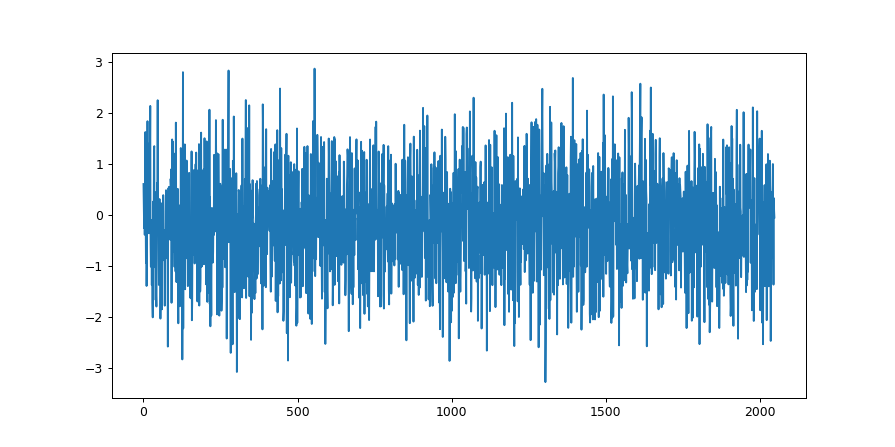

In [31]:
c = model.layers[1].get_weights()[0]
print(c.shape)
cs = c.reshape(64, 32, 3, 3)
print(cs.max(), cs.min())

s = []
for x in cs:
    for xx in x:
        s.append(np.sum(xx))
#         print(np.sum(xx))
        
plt.plot(s)
plt.show()
